# K-Means Clustering in Sports Analytics 

## Introduction

This tutorial will teach you how to perform K-Means clustering analysis in the field of Sports Analytics!


### What is Clustering?

Clustering is a form of **Unsupervised Learning**, a machine learning algorithm technique machine that works to label and classify raw data. This is in contrast to Supervised Learning algorithms, which most likely uses "cleaner" data with labels, classifications, and categories.

An example of **Supervised Learning** would be the following:

* Predicting a student's numeric grade on a midterm exam with variables of each student's hours of sleep, GPA, and hours of preparation.

An example of **Unsupervised Learning** would be the following:

* Finding a subgroup of an artist's songs based on their regional popularity.

In this tutorial, we will be diving into the applications of a certain clustering algorithm, **K-Means Clustering**.

### What is K-Means Clustering?

K-Means clustering is a clustering algorithm that serves to **branch a dataset of n observations into k clusters**, where each observation is **placed into the cluster with the nearest mean in respect to d dimensions**.

First, you choose an arbitrary k amount of observations from the dataset as centroids.

Then, you iterate through all the observations in the dataset, assigning each observation to a cluster and reassigning centroid points as necessary to minimize variances between datapoints in a cluster.

Your final result of applying the algorithm should be a dataset split into k clusters where the sum of the distance between observations in a centroid is minimized.


### Clustering in Sports Analytics

The digital age has brought upon a stunning change in professional sports organizations; teams are relying more and more on data driven decisions and research scientists to help make winning plays on the field. 

Thus, as databases and the overall datasets in the world of sports are rather new and "raw", the methods of Unsupervised Learning come into play. Clustering and other methods of Unsupervised Learning are optimized in situations and datasets with much to be learned, leaving sports analytics an ideal playground for these methods.

In this tutorial, we will explore clustering similiar types of players and teams!

## Datasets and Libraries

For this tutorial, we will use the following libraries.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import math
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import commonplayerinfo as commonInfo
from nba_api.stats.endpoints import leaguedashplayerstats as playerStats
from nba_api.stats.static import teams

We will acquire our first dataset from an NBA API package, which accesses game, player, and team data from NBA.com. We install the package with the following command.

In [ ]:
import sys
!{sys.executable} -m pip install nba-api

## Clustering with NBA Data

### Getting NBA Player Data

For my first clustering analysis, I want to try grouping similiar types of NBA players together! In order to continue with this, I want to get a dataframe with all the NBA players in a season with their respective stats. In the following chunk, I request all the data for every player in the 2018-2019 NBA season and convert it to a dataframe.

In [297]:
player_stats = playerStats.LeagueDashPlayerStats(season='2018-19')
df = player_stats.get_data_frames()[0]
print(df)

     PLAYER_ID      PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE  GP   W  \
0       203932     Aaron Gordon  1610612753               ORL  23.0  78  40   
1      1628988    Aaron Holiday  1610612754               IND  22.0  50  31   
2      1627846      Abdel Nader  1610612760               OKC  25.0  61  38   
3       201143       Al Horford  1610612738               BOS  33.0  68  41   
4       202329  Al-Farouq Aminu  1610612757               POR  28.0  81  52   
..         ...              ...         ...               ...   ...  ..  ..   
525     203897      Zach LaVine  1610612741               CHI  24.0  63  16   
526    1629155      Zach Lofton  1610612765               DET  26.0   1   1   
527       2585    Zaza Pachulia  1610612765               DET  35.0  68  35   
528    1629015     Zhaire Smith  1610612755               PHI  20.0   6   2   
529    1627753          Zhou Qi  1610612745               HOU  23.0   1   0   

      L  W_PCT          MIN  ...  BLKA_RANK  PF_RAN

Now that we have our raw dataframe, we want to clean the data so we work with relevant players and statistics. In the following chunk, I first filter for "box statistics", the most traditionally important statistics of an NBA player. After filtering for box statistics, I require that every player in the dataframe has played the statistical minimumal amount of games to qualify for NBA League Leaders. By doing so, I make sure there are no outliers in the data that will skew our analysis.

In [ ]:
traditionalDf = df[["PLAYER_ID", "PLAYER_NAME", "GP", "AGE", "FGM", "FGA", "FG3M", "FG_PCT",
         "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "REB", "AST", "TOV", "STL", "BLK", "PTS",
                   "NBA_FANTASY_PTS", "PLUS_MINUS_RANK"] ]
finalDisplay = df[["PLAYER_ID", "PLAYER_NAME","PTS",
                   "NBA_FANTASY_PTS_RANK", "PLUS_MINUS_RANK", "GP"] ]
qualified = traditionalDf[traditionalDf["GP"] >=  58]
finalDisplay = finalDisplay[finalDisplay["GP"] >= 58]
qualified = pd.DataFrame(qualified)
finalDisplay = pd.DataFrame(finalDisplay)
    

Now that we have our desired dataset, we proceed with our K-Means clustering algorithm.

### Using PCA to Transform Data

In [ ]:
scaler = StandardScaler()
pca = PCA()
numeric = qualified[["FG3M",
         "FG3_PCT", "REB", "AST", "BLK", "PTS",
                    "NBA_FANTASY_PTS", "PLUS_MINUS_RANK"] ]
standardized = scaler.fit_transform(numeric)
analyzed = pca.fit(standardized)
ratios = analyzed.explained_variance_ratio_
x = []
for i in range(len(ratios)):
    x.append(i)
cumsums = []
count = 0
for i in range(len(ratios)):
    count += ratios[i]
    cumsums.append(count)
total = 0
components = 0
for i in range(len(ratios)):
    total += ratios[i]
    if total > .90:
        components = i
        break
plt.plot(x, cumsums, 'o', color='black')
plt.plot(x, cumsums)

### K-Means Algorithm

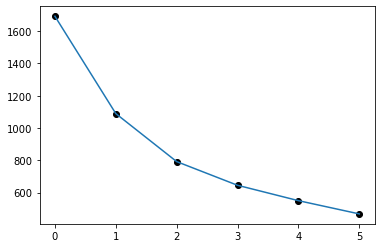

In [219]:
newPCA = PCA(n_components = components)
newPCA.fit(standardized)
transformPCA = newPCA.transform(standardized)
inertia = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(transformPCA)
    inertia += [kmeans.inertia_]
x = []
for i in range(len(inertia)):
    x.append(i)
plt.plot(x, inertia, 'o', color='black')
plt.plot(x, inertia)

In [288]:
final = KMeans(n_clusters = 3)
final.fit(transformPCA)
final.labels_
finalDisplay["cluster"] = final.labels_



In [348]:
finalPlayers = finalDisplay.sort_values(by='NBA_FANTASY_PTS_RANK', ascending=True)
print(finalPlayers[finalPlayers["cluster"] == 0])

     PLAYER_ID        PLAYER_NAME   PTS  NBA_FANTASY_PTS_RANK  \
225     201935       James Harden  2818                     1   
433     201566  Russell Westbrook  1675                     3   
407     202331        Paul George  2159                     4   
388     203999       Nikola Jokic  1604                     5   
45      203078       Bradley Beal  2099                     9   
..         ...                ...   ...                   ...   
93      201980        Danny Green   821                   125   
159     201569        Eric Gordon  1103                   142   
53     1627854        Bryn Forbes   967                   143   
168    1627832      Fred VanVleet   701                   149   
405     201988        Patty Mills   811                   153   

     PLUS_MINUS_RANK  GP  cluster  
225               22  78        0  
433               36  73        0  
407               10  77        0  
388               29  80        0  
45               439  82        0  
.. 

### Clustering Teams

In [327]:
from nba_api.stats.endpoints import leaguedashteamstats
allGames = leaguedashteamstats.LeagueDashTeamStats(season='2018-19')
teams = allGames.get_data_frames()[0]
for row in teams:
    print(row)
finalTeams = teams[["TEAM_ID", "TEAM_NAME", "W_PCT", "FG_PCT", "FG3A", "FG3_PCT", "FTA", "TOV", "PLUS_MINUS"]]
finalTeams = pd.DataFrame(finalTeams)
selected = teams[["FG_PCT", "FG3A", "FG3_PCT", "FTA", "TOV", "PLUS_MINUS"]]

TEAM_ID
TEAM_NAME
GP
W
L
W_PCT
MIN
FGM
FGA
FG_PCT
FG3M
FG3A
FG3_PCT
FTM
FTA
FT_PCT
OREB
DREB
REB
AST
TOV
STL
BLK
BLKA
PF
PFD
PTS
PLUS_MINUS
GP_RANK
W_RANK
L_RANK
W_PCT_RANK
MIN_RANK
FGM_RANK
FGA_RANK
FG_PCT_RANK
FG3M_RANK
FG3A_RANK
FG3_PCT_RANK
FTM_RANK
FTA_RANK
FT_PCT_RANK
OREB_RANK
DREB_RANK
REB_RANK
AST_RANK
TOV_RANK
STL_RANK
BLK_RANK
BLKA_RANK
PF_RANK
PFD_RANK
PTS_RANK
PLUS_MINUS_RANK
CFID
CFPARAMS


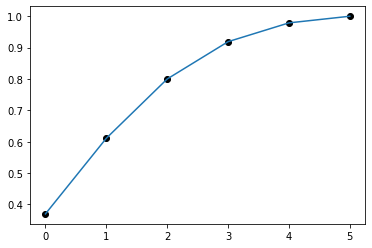

In [315]:
standardizedTeam = scaler.fit_transform(selected)
analyzedTeam = pca.fit(standardizedTeam)
ratiosTeam = analyzedTeam.explained_variance_ratio_
xTeam = []
for i in range(len(ratiosTeam)):
    xTeam.append(i)
cumsumsTeam = []
countTeam = 0
for i in range(len(ratiosTeam)):
    countTeam += ratiosTeam[i]
    cumsumsTeam.append(countTeam)
totalTeam = 0
componentsTeam = 0
for i in range(len(ratiosTeam)):
    totalTeam += ratiosTeam[i]
    if totalTeam > .90:
        componentsTeam = i
        break
plt.plot(xTeam, cumsumsTeam, 'o', color='black')
plt.plot(xTeam, cumsumsTeam)

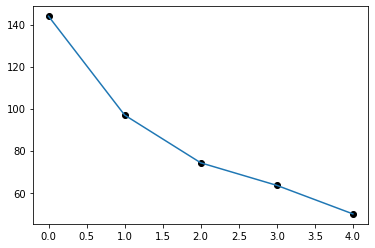

In [317]:
newPCATeam = PCA(n_components = componentsTeam)
newPCATeam.fit(standardizedTeam)

transformPCATeam = newPCATeam.transform(standardizedTeam)
inertiaTeam = []
for i in range(1, 6):
    kmeansTeam = KMeans(n_clusters= i)
    kmeansTeam.fit(transformPCATeam)
    inertiaTeam += [kmeansTeam.inertia_]
xTeam = []
for i in range(len(inertiaTeam)):
    xTeam.append(i)
plt.plot(xTeam, inertiaTeam, 'o', color='black')
plt.plot(xTeam, inertiaTeam)

In [335]:
finalTeam = KMeans(n_clusters = 2)
finalTeam.fit(transformPCATeam)
finalTeam.labels_

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1], dtype=int32)

In [342]:
finalTeams["cluster"] = finalTeam.labels_
sortedFinal = finalTeams.sort_values(by = ['W_PCT'], ascending = False)
print(sortedFinal[sortedFinal["cluster"] == 0])

       TEAM_ID               TEAM_NAME  W_PCT  FG_PCT  FG3A  FG3_PCT   FTA  \
16  1610612749         Milwaukee Bucks  0.732   0.476  3134    0.353  1904   
27  1610612761         Toronto Raptors  0.707   0.474  2771    0.366  1803   
9   1610612744   Golden State Warriors  0.695   0.491  2824    0.385  1672   
7   1610612743          Denver Nuggets  0.659   0.466  2571    0.351  1714   
24  1610612757  Portland Trail Blazers  0.646   0.467  2520    0.359  1914   
22  1610612755      Philadelphia 76ers  0.622   0.471  2474    0.359  2258   
28  1610612762               Utah Jazz  0.610   0.468  2789    0.356  2092   
1   1610612738          Boston Celtics  0.598   0.465  2829    0.365  1598   
12  1610612746             LA Clippers  0.585   0.471  2118    0.388  2340   
11  1610612754          Indiana Pacers  0.585   0.475  2081    0.374  1727   
26  1610612759       San Antonio Spurs  0.585   0.478  2071    0.392  1720   
25  1610612758        Sacramento Kings  0.476   0.464  2455    0